# SURFER - Experience A 

The aim is to see what the effect is on SURFER output variables such as surface temperature if we change the values of the coefficients for carbon fluxes between reservoirs, as well as ocean thermal conductivity. This variation in coefficients is designed to roughly simulate an AMOC shutdown.

We're looking for an initial quantitative analysis of the variations this implies in SURFER as it stands in v2.0 and then in the Victor's version with three oceanic box.

# SURFER v2.0
A simple model linking CO$_2$ emissions and solar radiation management to ocean acidification and sea level rise

In [1]:
using DifferentialEquations
using Plots
using DelimitedFiles
using Interpolations
using Roots
using LaTeXStrings

## model parameters and auxiliary expressions

In [2]:
#-----------------------------------------------------
# fixed CarbonCycle+Aerosol parameters
#-----------------------------------------------------
k_AU = 1/4              # 1/years                                                       | VARIABLE PARAMETER FOR EXPERIENCE A
h_U = 150             # m. Thickness of upper ocean layer
h_D =  h_U*20         # m. Thickness of lower ocean layer
δ = h_D/h_U           # h_L/h_U dimensionless 
δDIC = 1.15           # dimensionless DIC_L/DIC_U at pre industrial
k_UD = (δ * δDIC) / 1000    # 1/years                                                   | VARIABLE PARAMETER FOR EXPERIENCE A
K0 = 0.0314806         # mol/(kg atm) Henry CO2 solubility
K1 = 1.32648E-6        # mol/kg
K2 = 9.19803E-10     # mol/kg
mA = 1.727E20         # moles in atmosphere
mO = 7.8E22           # moles in ocean
GtCtoppm(M_A) = (M_A * 1E6 * 1E15)/(12*mA) # ppm in atmosphere/ PgC in atmosphere
ppmtoGtC(conc) = conc*12*mA/(1E21)
W_U = mO*18E-3*h_U/(h_U+h_D) # whole upper ocean mass kg
W_D = mO*18E-3*h_D/(h_U+h_D) # whole lower ocean mass kg
pH_PI = 8.17
H_PI = 10^(-pH_PI) # mol/kg
CO2conc_a_PI = 280 # ppm
pCO2_a(CO2conc_a) = CO2conc_a*1E-6 # atm
Q = (K1/H_PI + 2*K1*K2/H_PI^2)*K0*pCO2_a(CO2conc_a_PI) # mol/kg
Qm = Q*W_U*12E-3*1E-12 # PgC
k_AL = 1/40            #1/yr
β_L = 1.7             # dimensionless [0.5 - 2.3]
#-----------------------------------------------------
# pre industrial initial conditions for the carbon reservoirs
#-----------------------------------------------------
M_A_PI = ppmtoGtC(CO2conc_a_PI) # PgC
M_U_PI = M_A_PI*(1 + K1/H_PI + K1*K2/H_PI^2)*W_U*K0/mA     # PgC
M_D_PI = M_U_PI*δ*δDIC    # PgC
M_L_PI = 2200 # PgC
#-----------------------------------------------------
# parameters entering temperature c omputation (greenhouse and heat transport parameters)
#-----------------------------------------------------
ECS = 3.5            # Equilibrium CliM_Ae Sensitivity. Celcius / doubling of CO2
TCR = 2.0            # Transient CliM_Ae Response. Celcius / doubling of CO2
F2X = 3.9            # Watts / m^2. Forcing due to a doubling of CO2 concentration
β = F2X/ECS          # Watts / (m^2 Celcius). Inverse equilibrium cliM_Ae sensitivity.
γ = F2X / TCR - β      # Watts / (m^2 Celcius). Thermal conductivity between layers                       | VARIABLE PARAMETER FOR EXPERIENCE A
cvol = 0.13          # (Watts year) / (m^3 Celcius). Volumetric heat capacity of seawater.
TCR = F2X/(β+γ)      # Celsius per doubling of CO2 concentration
#-----------------------------------------------------
# parameters entering temperature computation (aerosol parameters taken from Helwegen2019, changed η)
#-----------------------------------------------------
#η = 0.742         # dimensionless
η = 1.0
αSO2 = 65        # Watts / m^2
βSO2 = 2246      # Mt of S / year
γSO2 = 0.23;     # dimensionless

#----------------------------------------------------
# a couple of auxiliary functions 
#----------------------------------------------------

function B(M_U) #dimensionles
    (sqrt( K1*( Qm*(K1-4K2)*(Qm-2M_U) + K1*M_U^2 ) ) - ( Qm*(K1-4K2) + M_U*(-K1+8K2) ) )/(2M_U*(K1-4K2))
end

function F(M_A,I) # antropogenic forcing
    if I > 0.0
        return F2X*log2(M_A/M_A_PI) - η*αSO2*exp(-(βSO2/I)^γSO2)
    else
        return F2X*log2(M_A/M_A_PI)
    end
end

function H(M_U) # Proton (hydrogen ion) concentration. mol/kg
    H = ( -Qm*K1 + K1*M_U + sqrt( K1*(Qm^2*(K1 - 4*K2) - 2*Qm*(K1 - 4*K2)*M_U + K1*M_U^2) ) )/(2*Qm)
    return H
end

function pH(M_U) # pH global scale
    return -log10(H(M_U))
end

function DIC(M_U) # μmol/kg
    return 1E6(M_U/12E-15)/(W_U)
end

function DIC_D(M_D) # μmol/kg
    return 1E6(M_D/12E-15)/(W_D)
end

function H2CO3(M_U) # μmol/kg
    H2CO3 = DIC(M_U)/(1 + K1/H(M_U) + K1*K2/H(M_U)^2)
    return H2CO3
end

function HCO3(M_U) # μmol/kg
    HCO3 = K1*H2CO3(M_U)/H(M_U)
    return HCO3
end

function CO3(M_U) # μmol/kg
    CO3 = K2*HCO3(M_U)/H(M_U)
    return CO3
end

CO3sat = CO3(M_U_PI)/3.44 

function Ω(M_U)
    return CO3(M_U)/CO3sat
end


#-----------------------------------------------------
# ICE parameters and functions
#-----------------------------------------------------

function Vmcons(model_parameters)
    
    Tp, Tm, Vp, Vm, τmelt, τfreeze = model_parameters
    
    x = ((-Tm + Tp)/(Tm + Tp + 2*sqrt(Tm*Tp)))^(1/3)
    Vm = ( -2 + Vp*(1 + x + 1/x ) )/( -1 + x + 1/x )
    
    return Vm
end

Greenland_params = [1.52, 0.3, 0.77, 0.3526554620064224, 470.0, 5000.0]#[Tp, Tm, Vp, Vm, tau_melt, tau_freeze] 
Greenland_params[4] = Vmcons(Greenland_params)
Antarctica_params = [6.8, 4, 0.44, 0.07857839308355193, 3000.0, 5500.0]#[Tp, Tm, Vp, Vm, tau_melt, tau_freeze] 
Antarctica_params[4] = Vmcons(Antarctica_params)
# sea level rise potential
SLRpotentialG = 7.4
SLRpotentialA = 55



function dV_dt(V, Tf, model_parameters)

    Tp, Tm, Vp, Vm, τmelt, τfreeze = model_parameters
    
    a = 3*(Vm + Vp)/2
    b = -3*Vm*Vp
    c = (Vp - Vm)^3/(2*(Tm - Tp))
    d = ( Tp*Vm^2*(Vm-3Vp) - Tm*Vp^2*(Vp-3Vm) )/(2*(Tm - Tp))
    
    function μ(V,Tf)
        if (- V^3 + a*V^2 + b*V + c*Tf + d) > 0
            return 1/τfreeze
        else
            if V < 1.0e-4
                return 0.0
            else
                return 1/τmelt
            end
        end
    end
       
    return μ(V,Tf)*(- V^3 + a*V^2 + b*V + c*Tf + d)
end

dV_dtA(V,Tf) = dV_dt(V,Tf,Antarctica_params)
dV_dtG(V,Tf) = dV_dt(V,Tf,Greenland_params) 


#-----------------------------------------------------------------------------------
# Sea level rise
#-----------------------------------------------------------------------------------
# SLR ice
SLR_G(VG) = SLRpotentialG*(1-VG)
SLR_A(VA) = SLRpotentialA*(1-VA)
SLRice(VG,VA) =  SLR_G(VG) + SLR_A(VA)
rateSLRice(VG,VA,δT_U) = - SLRpotentialG*(dV_dtG(VG,δT_U))*100 - SLRpotentialA*(dV_dtA(VA,δT_U))*100

# SLR thermal
αU = 2.3e-4 #K^-1
αD = 1.3e-4 #K^-1
SLRthermal(δT_U,δT_D;αU = αU, αD = αD) = αU*δT_U*h_U + αD*δT_D*h_D

# SLR glacier
τ_gl = 200 # years
SLRpotential_gl = 0.5 # meters
ζ = 2 # Related to equlibrium SLRglacier sensitivity to temperature change (Celsius)
SLRgl_eq(δT_U) = SLRpotential_gl*tanh(δT_U/ζ)
SLRglacier(S) = S

# SLRtotal(δT_U,δT_D,VG,VA,S)
SLRtotal(δT_U,δT_D,VG,VA,S) = SLRthermal(δT_U,δT_D) + SLRice(VG,VA) + SLRglacier(S)

SLRtotal (generic function with 1 method)

## model

In [3]:
function model!(du,u,p,t)
    M_A, M_U, M_D, M_L, δT_U, δT_D, VG, VA, S = u
    
    Emissions, Injections = p

    Tf = δT_U
    
    du[1] = dM_A = Emissions(t) - k_AU*(M_A - (mA/(W_U*K0))*B(M_U)*M_U) - k_AL*(β_L*M_A_PI*(1 - M_A_PI/M_A) - (M_L - M_L_PI))
    du[2] = dM_U = k_AU*(M_A - (mA/(W_U*K0))*B(M_U)*M_U) - k_UD*(M_U - M_D/(δ*δDIC))
    du[3] = dM_D = k_UD*(M_U - M_D/(δ*δDIC))
    du[4] = dM_L = k_AL*(β_L*M_A_PI*(1 - M_A_PI/M_A) - (M_L - M_L_PI))
    du[5] = dδT_U = ( F(M_A,Injections(t)) - β*δT_U - γ*(δT_U - δT_D) )/(cvol*h_U)
    du[6] = dδT_D = γ*(δT_U - δT_D)/(cvol*h_D)
    du[7] = dVG = dV_dtG(VG,Tf)
    du[8] = dVA = dV_dtA(VA,Tf)
    du[9] = dS = (1/τ_gl)*(SLRgl_eq(Tf) - S)
     
end

model! (generic function with 1 method)

## Load RCP and SSP emission scenarios

RCP

In [4]:
data_2p6 = readdlm("scenarios/RCP/rcp3");
data_4p5 = readdlm("scenarios/RCP/rcp4p5");
data_6 = readdlm("scenarios/RCP/rcp6");
data_8p5 = readdlm("scenarios/RCP/rcp8p5");
scenario_temp = [data_2p6,data_4p5,data_6,data_8p5];
rcp_names = ["RCP 2.6", "RCP 4.5", "RCP 6", "RCP 8.5"];
scenarios = []
for scenario in scenario_temp
    M_A = zeros(length(scenario[:,1]),2)
    M_A[:,1] = scenario[:,1]
    M_A[:,2] = scenario[:,2] + scenario[:,3]
    push!(scenarios,M_A)
end

#extend scenarios with zero emissions after 2300
extension = zeros(length(2501:15000),2)
extension[:,1] = [year for year in 2501:15000];
ext_scenarios = []
for scenario in scenarios
    push!(ext_scenarios,reduce(vcat, [scenario,extension]))
end
for scenario in ext_scenarios
    scenario[scenario[:,1] .>= 2300,2] = zeros(length(scenario[scenario[:,1] .>= 2300,2]))
end

#itp = LinearInterpolation(data[:,1], data[:,2]) # create interpolation function
rcp_itp = []
for i in 1:length(ext_scenarios)
    itp = LinearInterpolation(ext_scenarios[i][:,1],ext_scenarios[i][:,2])
    push!(rcp_itp,itp)
end

SSP

In [5]:
data_ssp = readdlm("scenarios/SSP/ssp");
ssp_names = data_ssp[2:end,1];
ssp_temp = [data_ssp[i,5:end]*12*1e-3/((12+32)) for i in 2:5]
ssp_time = data_ssp[1,5:end]
# get historic emissions from the RCP scenarios as they were not included in the SSP dataset
yearsbefore = [i for i in 1765:1:1989]
historic_em = rcp_itp[1].(yearsbefore)
yearsafter = [i for i in 2101:2250]
yearsafter2 = [i for i in 2251:12000]
allyears = vcat(yearsbefore,ssp_time,yearsafter,yearsafter2)
ssp_itp = []
for i in 1:4
    em2100 = ssp_temp[i][end]
    # linear decarbonisation that ends in 2250. 
    # Different decarbonisation rates for the different scenarios, as in SSP extrensions paper.
    emafter = [-em2100*(t-2100)/150 + em2100 for t in yearsafter]
    # zero emissions after decarbonisation
    emafter2 = zeros(length(yearsafter2))
    allem= vcat(historic_em,ssp_temp[i],emafter,emafter2)
    em = LinearInterpolation(allyears,allem);
    push!(ssp_itp,em)
end
ssp_names = copy(ssp_names[[2,3,1,4]])
ssp_itp = copy(ssp_itp[[2,3,1,4]]);

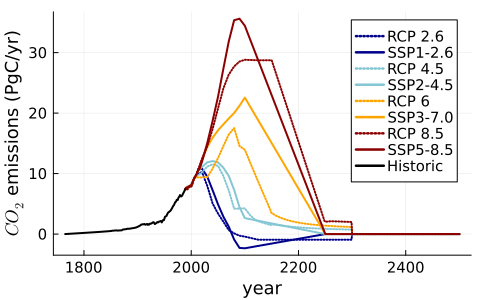

In [6]:
#-----------------------------------------------------------------------
colors = [palette(:blues)[2],palette(:ice)[200],palette(:heat)[2],palette(:heat)[3]]
p = plot(xtickfont=font(10), 
    ytickfont=font(10), 
    guidefont=font(12), 
    legendfont=font(10))
t_start = 1800
t_final = 2500
for i in 1:length(scenarios)
    time = [t for t in 1989:0.1:t_final]
    plot!(time,rcp_itp[i].(time), 
        label = rcp_names[i], lw=2,color=colors[i],ls=:dot)
    plot!(time,ssp_itp[i].(time), 
        label = ssp_names[i], lw=2,color=colors[i])
end
t_historic = [t for t in 1765:0.1:1989]
plot!(t_historic,rcp_itp[1].(t_historic),label="Historic",lc=:black,lw=2,size=(1.61*300,300))
ylabel!(L"CO_2"*" emissions (PgC/yr)")
xlabel!("year")

## Experience A.0 : Control Run with SSP2-4.5

### Control Run
We run SURFER on every SSP Scenarios from 1800 to 4000 years and then we will only focus on SSP2-4.5 

In [7]:
sol_list_ssp = []
for i in 1:4
    tspan = (1765.0, 4000.0) # time interval
    #ssp
    u₀ = [M_A_PI, M_U_PI, M_D_PI, M_L_PI, 0.0, 0.0, 1.0, 1.0, 0.0] # initial state vector
    sources = [ssp_itp[i], t -> 0.0] # [co2rate, so2rate]
    prob = ODEProblem(model!, u₀, tspan, sources)
    @time sol = solve(prob, Rosenbrock23(), reltol=1e-3, abstol=1e-12)
    push!(sol_list_ssp, sol)
end

println("-----------------------------")
println(sol_list_ssp)
println(size(sol_list_ssp))
println(length(sol_list_ssp[1]))

 13.294467 seconds (27.13 M allocations: 2.178 GiB, 4.67% gc time, 99.86% compilation time)
  0.002126 seconds (78.63 k allocations: 2.288 MiB)
  0.032859 seconds (82.93 k allocations: 2.419 MiB, 93.53% gc time)
  0.001968 seconds (84.90 k allocations: 2.477 MiB)
-----------------------------
Any[ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{Float64}}}, ODEProblem{true,Vector{Float64},Tuple{Float64, Float64},…}, Rosenbrock23{9,true,…}, OrdinaryDiffEq.InterpolationData{ODEFunction{true,SciMLBase.AutoSpecialize,…}, Vector{Vector{Float64}}, Vector{Float64}, Vector{Vector{Vector{Float64}}}, Rosenbrock23Cache{Vector{Float64},…}}, DiffEqBase.DEStats, Nothing}([[580.2719999999999, 1583.3315953916112, 36416.626694007056, 2200.0, 0.0, 0.0, 1.0, 1.0, 0.0], [580.2720004267064, 1583.3315953916187, 36416.626694007056, 2200.0000000000014, 1.5087728033350692e-14, 1.904585148511364e-21, 1.0, 1.0, 1.1110078323434371e-21], [580.2720046987337, 15

Excessive output truncated after 524307 bytes.

 -1.2895378252726367e-9, -5.317913554958667e-10, 2.5328562055516833e-8]], [[0.017841623534183334, 0.0031664941308150217, 0.0001340216236372393, 0.001615560920748363, 1.7064602084269676e-5, 5.387729182492153e-8, -1.5957450036547067e-9, -6.580792762774402e-10, 3.13325545915505e-8], [0.018153706935713096, 0.0032367171192201, 0.00014035012240793773, 0.0016775484227126538, 1.7680769601922765e-5, 5.711107718525877e-8, -1.6915753659428664e-9, -6.976031353282365e-10, 3.3210751401758323e-8]], [[0.019388780362467863, 0.003514653047720925, 0.00016624858127551603, 0.0019293130094328527, 2.017228101929765e-5, 7.05888520722225e-8, -2.0909998259628517e-9, -8.623416758258082e-10, 4.1037646884090665e-8], [0.019727811419317624, 0.0035909608944491135, 0.00017398816718299282, 0.0020031707926674983, 2.0894879367559476e-5, 7.480131922524668e-8, -2.2158571353912084e-9, -9.138390799985165e-10, 4.348311594242592e-8]], [[0.021070447103649255, 0.003893158701159438, 0.0002056774599173893, 0.002303423805591354, 2.

### Control Run - Plot some relevant quantities 

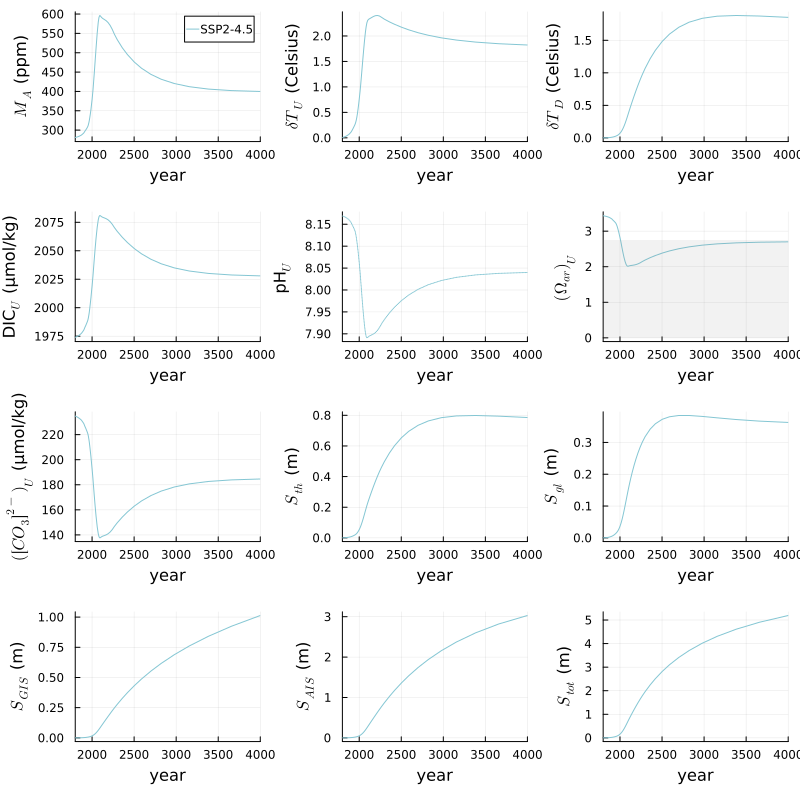

In [22]:
time_list = [t for t in 1765:0.1:4000]
p = plot(xrange=(1800, 4000), xlabel="year", layout=(4, 3), size=(800, 800))

iscen = 2

time = sol_list_ssp[iscen].t
M_A = sol_list_ssp[iscen][1, :]
M_U = sol_list_ssp[iscen][2, :]
δT_U = sol_list_ssp[iscen][5, :]
δT_D = sol_list_ssp[iscen][6, :]
VG = sol_list_ssp[iscen][7, :]
VA = sol_list_ssp[iscen][8, :]
S = sol_list_ssp[iscen][9, :]
plot!(time, GtCtoppm.(M_A), color=colors[iscen], ylabel=L"M_A"*" (ppm)", lw=1, label=ssp_names[iscen], subplot=1)
plot!(time, δT_U, color=colors[iscen], ylabel=L"\delta T_U" * " (Celsius)", lw=1, label=false, subplot=2)
plot!(time, δT_D, color=colors[iscen], ylabel=L"\delta T_D" * " (Celsius)", lw=1, label=false, subplot=3)
plot!(time, DIC.(M_U), color=colors[iscen], ylabel="DIC" * L"_U" * " (μmol/kg)", lw=1, label=false, subplot=4)
plot!(time, pH.(M_U), color=colors[iscen], ylabel="pH" * L"_U", ls=:dot, lw=1, label=false, subplot=5)
plot!(time, Ω.(M_U), color=colors[iscen], ylabel=L"(\Omega_{ar})_U", lw=1, label=false, subplot=6)
plot!(time, CO3.(M_U), color=colors[iscen], ylabel=L"([CO_3]^{2-})_U" * " (μmol/kg)", lw=1, label=false, subplot=7)
plot!(time, SLRthermal.(δT_U, δT_D), color=colors[iscen], ylabel=L"S_{th}" * " (m)", lw=1, label=false, subplot=8)
plot!(time, SLRglacier.(S), color=colors[iscen], ylabel=L"S_{gl}" * " (m)", lw=1, label=false, subplot=9)
plot!(time, SLRpotentialG * (1 .- VG), color=colors[iscen], ylabel=L"S_{GIS}" * " (m)", lw=1, label=false, subplot=10)
plot!(time, SLRpotentialA * (1 .- VA), color=colors[iscen], lw=1, ylabel=L"S_{AIS}" * " (m)", label=false, subplot=11)
plot!(time, SLRtotal.(δT_U, δT_D, VG, VA, S), color=colors[iscen], ylabel=L"S_{tot}" * " (m)", lw=1, label=false, subplot=12)

hline!([2.75], label=false, legend=:bottomleft, lc=:gray, alpha=0, fill=(0, 0.1, :gray), subplot=6)
p